# **S&P 500 Close Price Prediction**

## **Load Libraries**

In [1]:
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import mean_squared_error
import time
from IPython.display import display
import joblib

## **Load Historical Data**

In [2]:
def get_history(stock_name, duration = None, start_time = None, end_time = None):
    stock = yf.Ticker(stock_name)
    if duration:
        data = stock.history(period = duration)
    elif start_time and end_time:
        data = stock.history(start = start_time, end = end_time)
    return data

In [3]:
data_history = get_history("^GSPC", "5y")
display(data_history)
data_history = data_history[["Close"]]

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-04-29 00:00:00-04:00,2940.580078,2949.520020,2939.350098,2943.030029,3150390000,0.0,0.0
2019-04-30 00:00:00-04:00,2937.139893,2948.219971,2924.110107,2945.830078,3939760000,0.0,0.0
2019-05-01 00:00:00-04:00,2952.330078,2954.129883,2923.360107,2923.729980,3669330000,0.0,0.0
2019-05-02 00:00:00-04:00,2922.159912,2931.679932,2900.500000,2917.520020,3802290000,0.0,0.0
2019-05-03 00:00:00-04:00,2929.209961,2947.850098,2929.209961,2945.639893,3357180000,0.0,0.0
...,...,...,...,...,...,...,...
2024-04-22 00:00:00-04:00,4987.330078,5038.839844,4969.399902,5010.600098,3820250000,0.0,0.0
2024-04-23 00:00:00-04:00,5028.850098,5076.120117,5027.959961,5070.549805,3751400000,0.0,0.0
2024-04-24 00:00:00-04:00,5084.859863,5089.479980,5047.020020,5071.629883,3656740000,0.0,0.0


## **Split the Dataset**

In [4]:
def get_window(data, size):
    X1, y1 = [], []
    for i in range(size, len(data)):
        X1.append(data.iloc[i - size:i])
        y1.append(data.iloc[i])
    X1 = np.array(X1)
    y1 = np.array(y1)
    return X1, y1

In [5]:
length_train = int(0.7 * len(data_history))
length_val = int(0.15 * len(data_history))

data_train = data_history[:length_train]
data_val = data_history[length_train:length_train + length_val]
data_test = data_history[length_train + length_val:]

## **Model Architecture**

### **LSTM**

In [6]:
def lstm(**params):
    model = keras.Sequential([
        layers.Input(shape=(params["window_size"], 1)),

        layers.LSTM(params["lstm_size"][0], return_sequences=True),
        layers.LSTM(params["lstm_size"][1], return_sequences=False),

        layers.Dense(params["fc_size"]),
        layers.Dense(1)
    ])

    model.compile(optimizer=params["optimizer"], loss="mse")

    return model

### **RNN**

In [7]:
def rnn(**params):
    model = keras.Sequential([
        layers.Input(shape=(params["window_size"], 1)),
    
        layers.SimpleRNN(params["rnn_size"][0], return_sequences=True),
        layers.SimpleRNN(params["rnn_size"][1], return_sequences=False),

        layers.Dense(params["fc_size"]),
        layers.Dense(1)
    ])

    model.compile(optimizer=params["optimizer"], loss="mse")
    
    return model

### **LSTM + CNN**

In [8]:
def lstm_cnn(**params):
    model = keras.Sequential([
        layers.Input(shape=(params["window_size"], 1)),
    
        layers.Conv1D(filters=params["filters_size"][0], kernel_size=2, dilation_rate=1, activation='relu'),
        layers.Conv1D(filters=params["filters_size"][1], kernel_size=2, dilation_rate=2, activation='relu'),
        
        layers.LSTM(params["lstm_size"], return_sequences=False),
        
        layers.Dense(1)
    ])

    model.compile(optimizer=params["optimizer"], loss="mse")

    return model

### **GRU + CNN**

In [9]:
def gru_cnn(**params):
    model = keras.Sequential([
        layers.Input(shape=(params["window_size"], 1)),
        
        layers.Conv1D(filters=params["filters_size"][0], kernel_size=2, dilation_rate=1, activation='relu'),
        layers.Conv1D(filters=params["filters_size"][1], kernel_size=2, dilation_rate=2, activation='relu'),
        
        layers.GRU(params["gru_size"], return_sequences=False),

        layers.Dense(30),
        layers.Dense(1)
    ])
    
    model.compile(optimizer=params["optimizer"], loss="mse")

    return model

## **Hyperparameter Tuning**

In [10]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
    verbose=1
)

# Use RMSE as metric
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def grid_search(model_name, param_grid):

    # Go through all possible combinations
    keys = param_grid.keys()
    values = param_grid.values()
    param_combinations = itertools.product(*values)
    param_dicts = [dict(zip(keys, combination)) for combination in param_combinations]

    # Initialization
    pred_results = []
    best_rmse = float('inf')
    best_params = {}
    

    for i, params in enumerate(param_dicts):

        print(f"({i + 1}/{len(param_dicts)}): {params}")

        # Choose a model
        if model_name == "lstm":
            model = lstm(**params)
        elif model_name == "rnn":
            model = rnn(**params)
        elif model_name == "lstm_cnn":
            model = lstm_cnn(**params)
        elif model_name == "gru_cnn":
            model = gru_cnn(**params)

        # Split the train data according to the window size
        X_train, y_train = get_window(data_train, params["window_size"])
        X_val, y_val = get_window(data_val, params["window_size"])

        # Normalization
        scaler = MinMaxScaler()

        X_train_normalized = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(len(X_train), params["window_size"], 1)
        y_train_normalized = scaler.transform(y_train.reshape(-1, 1)).reshape(len(X_train), 1)

        X_val_normalized = scaler.transform(X_val.reshape(-1, 1)).reshape(len(X_val), params["window_size"], 1)
        y_val_normalized = scaler.transform(y_val.reshape(-1, 1)).reshape(len(X_val), 1)

        # Train the model
        start_time = time.time()
        model.fit(X_train_normalized, y_train_normalized, epochs = 100, validation_data=(X_val_normalized, y_val_normalized), callbacks=[early_stopping])
        runtime = time.time() - start_time

        # Get the prediction
        y_pred = model.predict(X_val_normalized)
        y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

        # Evaluate the model performance
        rmse_result = rmse(y_val, y_pred)

        # Update the best results
        if rmse_result < best_rmse:
            best_rmse = rmse_result
            best_params = params
            best_model = model

        # Record the results
        pred_results.append({"params" : params, "y_pred" : y_pred, "training_time": runtime})

    return pred_results, best_rmse, best_params, best_model, scaler

def plot_save_search_results(model_name, results):
    # print the results
    print("best_hyperparameters:", results[2])
    print("rmse:", results[1])

    # Save the model
    results[3].save(f"{model_name}_model.keras")
    joblib.dump(results[4], f"{model_name}_scaler.pkl")
    y_pred = [item["y_pred"] for item in results[0]]

    # Compare the prediction with original data
    plt.figure()
    _, y_val = get_window(data_val, results[2]["window_size"])
    plt.plot(y_val, label='true', color='black')
    for idx, sublist in enumerate(y_pred):
        plt.plot(sublist, label=f'{results[0][idx]["params"]}', linestyle='--')
    plt.legend(
        loc='center left',
        bbox_to_anchor=(1, 0.5),
        fontsize=7
    )
    plt.title(f"Grid Search Results of {model_name}")
    plt.xlabel("Time")
    plt.ylabel("S&P 500")
    plt.show()

### **LSTM**

In [16]:
param_grid_lstm = {
    "window_size" : [5, 10, 15],
    "lstm_size" : [[64, 64], [32, 32]],
    "fc_size" : [30, 20],
    "optimizer" : ["adam", "sgd"]
}

lstm_results = grid_search(model_name = "lstm", param_grid = param_grid_lstm)

(1/24): {'window_size': 5, 'lstm_size': [64, 64], 'fc_size': 30, 'optimizer': 'adam'}
Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.1308 - val_loss: 0.0183
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0074 - val_loss: 0.0010
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0018 - val_loss: 5.3677e-04
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0010 - val_loss: 6.1772e-04
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.4877e-04 - val_loss: 6.9179e-04
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.2738e-04 - val_loss: 5.4069e-04
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.4052e-04 - val_loss: 6.2889e-04
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.7587e-04 - val_loss: 7.8737e-04
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.9834e-04 - val_loss: 6.9207e-04
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.0962e-04 - val_loss: 6.7817e-04
Epoch 

best_hyperparameters: {'window_size': 5, 'lstm_size': [32, 32], 'fc_size': 20, 'optimizer': 'adam'}
rmse: 61.14556688130685


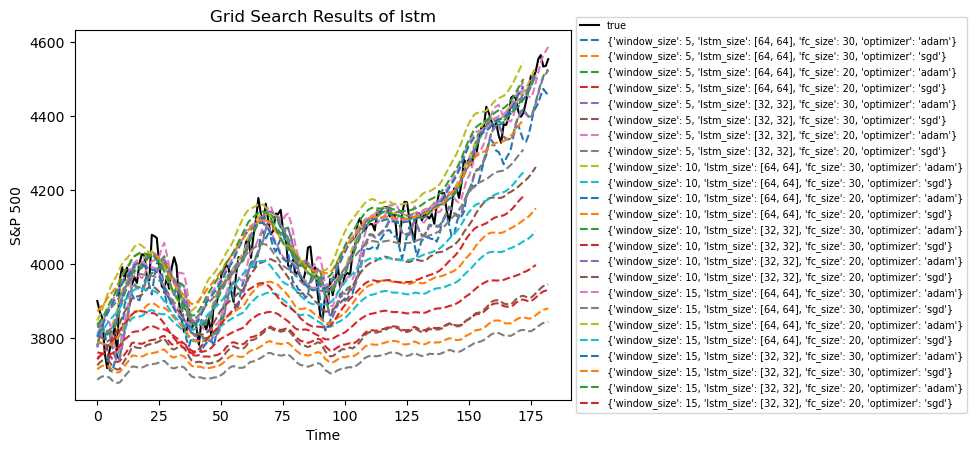

In [17]:
plot_save_search_results("lstm", lstm_results)

### **RNN**

In [63]:
param_grid_rnn = {
    "window_size" : [5, 10, 15],
    "rnn_size" : [[64, 64], [32, 32]],
    "fc_size" : [30, 20],
    "optimizer" : ["adam", "sgd"]
}

rnn_results = grid_search(model_name = "rnn", param_grid = param_grid_rnn)

(1/24): {'window_size': 5, 'rnn_size': [64, 64], 'fc_size': 30, 'optimizer': 'adam'}
Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.2268 - val_loss: 0.0187
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0065 - val_loss: 0.0011
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0016 - val_loss: 7.8956e-04
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0013 - val_loss: 7.7533e-04
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0010 - val_loss: 6.2789e-04
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.4509e-04 - val_loss: 6.0825e-04
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.5577e-04 - val_loss: 6.9531e-04
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.2007e-04 - val_loss: 6.1949e-04
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7.7263e-04 - val_loss: 4.7744e-04
Epoch 10: early sto

best_hyperparameters: {'window_size': 5, 'rnn_size': [64, 64], 'fc_size': 20, 'optimizer': 'adam'}
rmse: 55.995070029754615


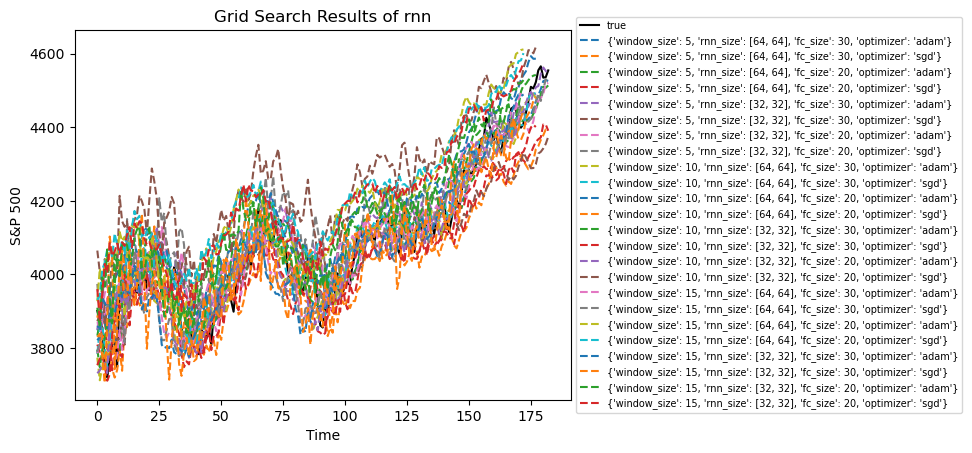

In [64]:
plot_save_search_results("rnn", rnn_results)

### **LSTM + CNN**

In [72]:
param_grid_lstm_cnn = {
    "window_size" : [5, 10, 15],
    "filters_size" : [[16, 16], [32, 32]],
    "lstm_size" : [64, 32],
    "optimizer" : ["adam", "sgd"]
}

lstm_cnn_results = grid_search(model_name = "lstm_cnn", param_grid = param_grid_lstm_cnn)

(1/24): {'window_size': 5, 'filters_size': [16, 16], 'lstm_size': 64, 'optimizer': 'adam'}
Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.2636 - val_loss: 0.0157
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0159 - val_loss: 0.0097
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0093 - val_loss: 0.0015
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0034 - val_loss: 6.3023e-04
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.2683e-04 - val_loss: 5.9033e-04
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.0310e-04 - val_loss: 6.3953e-04
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.1940e-04 - val_loss: 6.9538e-04
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.4380e-04 - val_loss: 6.2079e-04
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.9200e-04 - val_loss: 5.5454e-04
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 8.6815e-04 - val_loss: 5.4359e-04
Epoch

best_hyperparameters: {'window_size': 5, 'filters_size': [16, 16], 'lstm_size': 32, 'optimizer': 'adam'}
rmse: 51.79353498529065


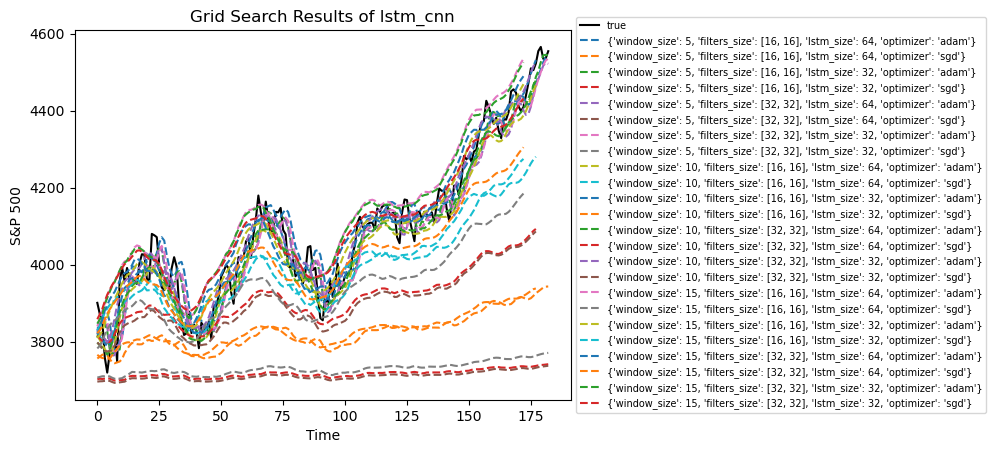

In [73]:
plot_save_search_results("lstm_cnn", lstm_cnn_results)

### **GRU + CNN**

In [74]:
param_grid_gru_cnn = {
    "window_size" : [5, 10, 15],
    "filters_size" : [[16, 16], [32, 32]],
    "gru_size" : [64, 32],
    "optimizer" : ["adam", "sgd"]
}

gru_cnn_results = grid_search(model_name = "gru_cnn", param_grid = param_grid_gru_cnn)

(1/24): {'window_size': 5, 'filters_size': [16, 16], 'gru_size': 64, 'optimizer': 'adam'}
Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.2210 - val_loss: 0.0078
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0093 - val_loss: 7.4292e-04
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0030 - val_loss: 6.3883e-04
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 9.7095e-04 - val_loss: 4.9882e-04
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.4804e-04 - val_loss: 4.9903e-04
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.5502e-04 - val_loss: 5.1824e-04
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.4534e-04 - val_loss: 4.9155e-04
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.2123e-04 - val_loss: 5.2294e-04
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 7.8337e-04 - val_loss: 4.4592e-04
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 6.9873e-04 - val_loss: 4.235

best_hyperparameters: {'window_size': 10, 'filters_size': [32, 32], 'gru_size': 64, 'optimizer': 'adam'}
rmse: 49.66683444033897


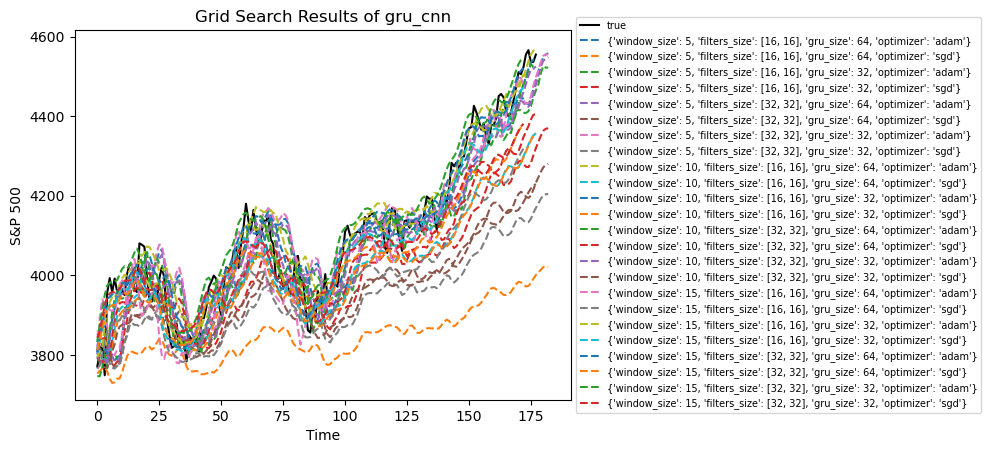

In [75]:
plot_save_search_results("gru_cnn", gru_cnn_results)

## **Final Model Architecture and Evaluation**

In [27]:
def plot_test_results(model_name, window_size, model):
    #Load the scaler
    scaler = joblib.load(f'{model_name}_scaler.pkl')

    # Normalize the test data
    X_test, y_test = get_window(data_test, window_size)
    X_test_normalized = scaler.transform(X_test.reshape(-1, 1)).reshape(len(X_test), window_size, 1)

    # Utilize the best model
    y_pred = model.predict(X_test_normalized)
    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

    # Evaluate the performance
    print("rmse(test):", rmse(y_test, y_pred))

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label='True', linestyle='-', color='b')
    plt.plot(y_pred, label='Pred', linestyle='--', color='r')
    plt.title(f"True vs Pred ({model_name})")
    plt.xlabel("Time")
    plt.ylabel("S&P 500 Close Price")
    plt.legend()
    plt.show()

### **LSTM**

In [14]:
lstm = keras.models.load_model("lstm_model.keras")
# print the architecture
lstm.summary()

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_60 (LSTM)                  │ (None, 5, 32)          │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_61 (LSTM)                  │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 20)             │           660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,061 (156.49 KB)

 Trainable params: 13,353 (52.16 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 26,708 (104.33 KB)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
rmse(test): 84.68920386604806


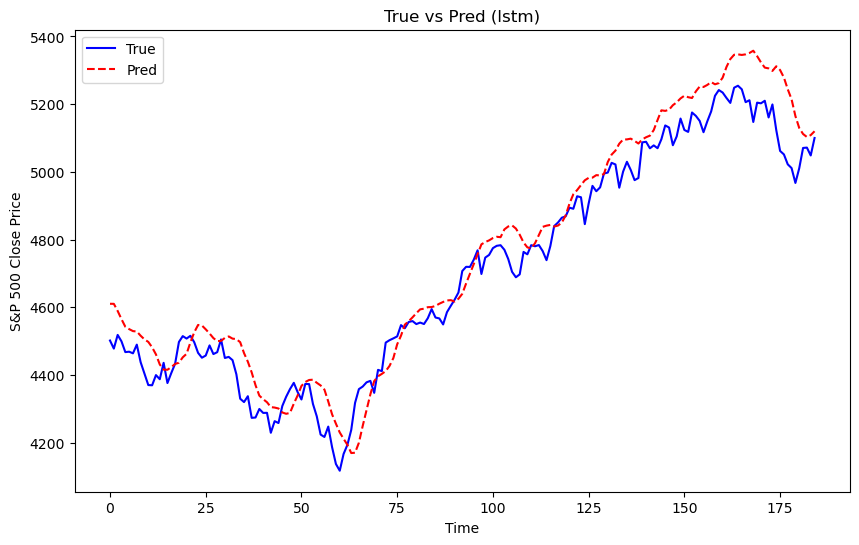

In [28]:
plot_test_results("lstm", 5, lstm)

### **RNN**

In [20]:
rnn = keras.models.load_model("rnn_model.keras")
# print the architecture
rnn.summary()

Model: "sequential_267"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_100 (SimpleRNN)      │ (None, 5, 64)          │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_101 (SimpleRNN)      │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_461 (Dense)               │ (None, 20)             │         1,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_462 (Dense)               │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,405 (161.74 KB)

 Trainable params: 13,801 (53.91 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 27,604 (107.83 KB)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
rmse(test): 103.26641246087334


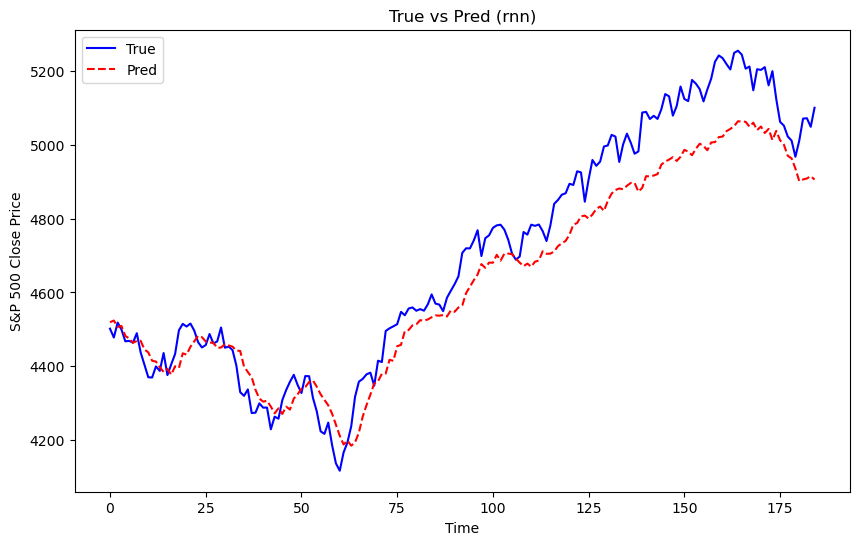

In [29]:
plot_test_results("rnn", 5, rnn)

### **LSTM + CNN**

In [22]:
lstm_cnn = keras.models.load_model("lstm_cnn_model.keras")
# print the architecture
lstm_cnn.summary()

Model: "sequential_339"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_438 (Conv1D)             │ (None, 4, 16)          │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_439 (Conv1D)             │ (None, 2, 16)          │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_219 (LSTM)                 │ (None, 32)             │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_579 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,645 (80.65 KB)

 Trainable params: 6,881 (26.88 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,764 (53.77 KB)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
rmse(test): 49.75321305616178


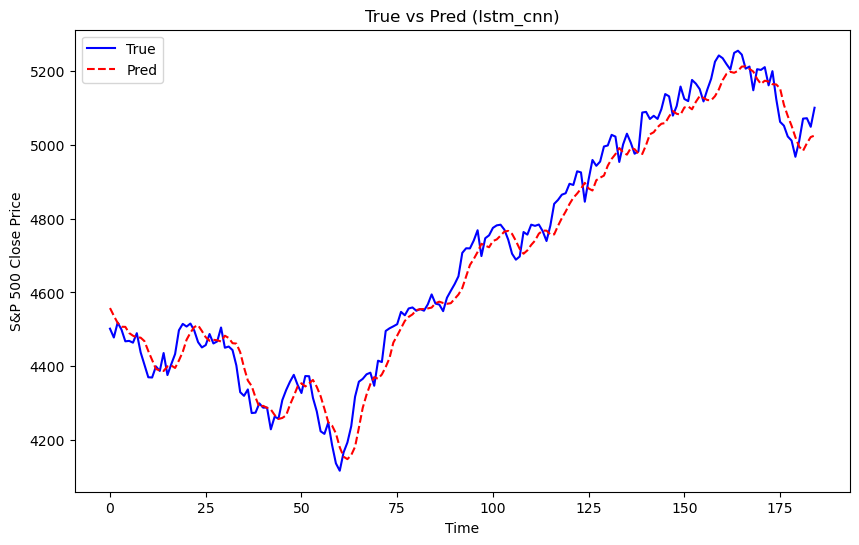

In [30]:
plot_test_results("lstm_cnn", 5, lstm_cnn)

### **GRU + CNN**

In [24]:
gru_cnn = keras.models.load_model("gru_cnn_model.keras")
# print the architecture
gru_cnn.summary()

Model: "sequential_373"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_506 (Conv1D)             │ (None, 9, 32)          │            96 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_507 (Conv1D)             │ (None, 7, 32)          │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_108 (GRU)                   │ (None, 64)             │        18,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_625 (Dense)               │ (None, 30)             │         1,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_626 (Dense)               │ (None, 1)              │            31 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,921 (269.23 KB)

 Trainable params: 22,973 (89.74 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 45,948 (179.49 KB)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
rmse(test): 49.0616346319517


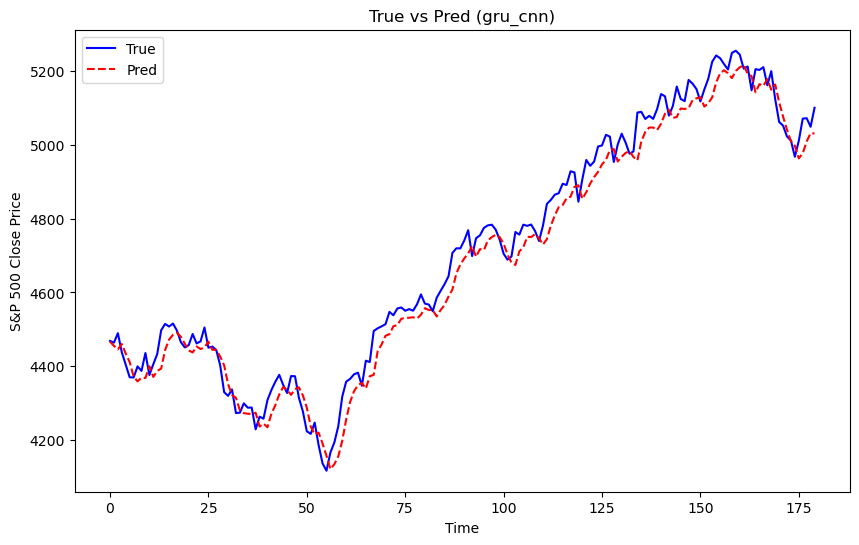

In [31]:
plot_test_results("gru_cnn", 10, gru_cnn)